### Isolate Baits with 2 Replicates and Perform Contamination Analysis
- import combined summary sheet with experiment number labeled (before removing excess replicates)
- find and plot examples of contamination (drift between samples)
- fit to exponential decay profiles and subtract from counts

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import seaborn as sns # heatmaps
from tqdm import tqdm # progress bars


In [2]:
# >> User Inputs <<
import_file = "20240724_PBv6_BaitPreyInfo_20240529_combineIsoforms_20240521_summary_baitCre_LWcorrected_expGelNums.xlsx"
out_name = 'flagged_' + import_file # contamination flagged summary sheet output filename
spectral_threshold = 1 # values below threshold are set to 0

In [3]:
# plot formatting
fontSize = 20
fontName = 'Arial';

plt.rcParams.update({'font.family': fontName,
                     'font.size': fontSize,
                     'axes.titlesize': fontSize,
                     'xtick.labelsize': fontSize,
                     'ytick.labelsize': fontSize,
                     'axes.formatter.use_mathtext': False})

plotStyle = {'markersize': 8, 'markeredgewidth': 3, 'linewidth': 3, 'markerfacecolor':'w'}
gridStyle = {'linewidth':0.9, 'color': 'silver'}

# colorblind friendly color scheme
color_spec = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628',
              '#984ea3', '#999999', '#e41a1c', '#dede00']


In [4]:
# import data (takes a few mins)

full_sheet = pd.read_excel(import_file, 
                           sheet_name = 0,
                           index_col = None) # load from sheet 1



In [5]:
full_sheet

,Unnamed: 0,Identified Proteins,Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Taxonomy,geneName,exp,PB-Chlamy,...,2722,2723,2724,2725,2726,2727,2728,2730,2731,2733
0,Sheet Number,0,0,0,0,0,0,0,0,0,...,77,77,77,77,77,77,77,77,77,77
1,Gel Number,0,0,0,0,0,0,0,0,0,...,351,351,351,351,352,352,352,352,352,352
2,Bait CreID,0,0,0,0,0,0,0,0,0,...,Cre12.g557250,Cre16.g692751,Cre04.g222700,Cre17.g731150,Cre10.g460050,Cre11.g467722,Cre17.g723650,Cre10.g419800,Cre03.g169400,Cre09.g396100
3,Bait Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1703_1202_85_11G9,LW_1703_1202_86_11C12,LW_1703_1202_87_11H4,LW_1703_1202_88_11G1,LW_1703_1202_89_11F7,LW_1703_1202_90_11F9,LW_1703_1202_91_11F6,LW_1703_1202_93_11F2,LW_1703_1202_94_11H6,LW_1703_1202_96_11H10
4,Bait Gene Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not Found,PDI3,EF3,Not Found,FLU1,Not Found,KAT1,PIS1,UXS1,PHC15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13410,13398,pacid=52510722 transcript=Cre03.g156600_4532.1...,Cre03.g156600_4532.1.p,Cre03.g156600,32 kDa,0,Cre03.g156600,GTRBP1,chloroplast/not homogeneous/not pyrenoid depleted,Chloroplast,...,0,0,0,0,1,0,0,0,0,0
13411,13399,pacid=52540355 transcript=Cre04.g216300_4532.1...,Cre04.g216300_4532.1.p,Cre04.g216300,18 kDa,0,Cre04.g216300,Not Found,Not Found,Other,...,0,0,0,0,0,0,0,0,0,0
13412,13400,pacid=52517051 transcript=Cre16.g653650_4532.1...,Cre16.g653650_4532.1.p,Cre16.g653650,22 kDa,0,Cre16.g653650,Not Found,Not Found,Chloroplast,...,0,0,0,0,0,0,0,0,1,0
13413,13401,pacid=52534323 transcript=Cre08.g377000_4532.1...,Cre08.g377000_4532.1.p,Cre08.g377000,10 kDa,0,Cre08.g377000,Not Found,secretory pathway/contractile vacuole; shapes ...,Secretory,...,0,0,0,0,0,0,0,0,0,0


In [14]:
sheet = full_sheet.iloc[:,1:].copy()
sheet.index = full_sheet.iloc[:,0]
sheet.columns = full_sheet.iloc[3,1:]

In [15]:
sheet

3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1703_1202_85_11G9,LW_1703_1202_86_11C12,LW_1703_1202_87_11H4,LW_1703_1202_88_11G1,LW_1703_1202_89_11F7,LW_1703_1202_90_11F9,LW_1703_1202_91_11F6,LW_1703_1202_93_11F2,LW_1703_1202_94_11H6,LW_1703_1202_96_11H10
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Sheet Number,0,0,0,0,0,0,0,0,0,0,...,77,77,77,77,77,77,77,77,77,77
Gel Number,0,0,0,0,0,0,0,0,0,0,...,351,351,351,351,352,352,352,352,352,352
Bait CreID,0,0,0,0,0,0,0,0,0,0,...,Cre12.g557250,Cre16.g692751,Cre04.g222700,Cre17.g731150,Cre10.g460050,Cre11.g467722,Cre17.g723650,Cre10.g419800,Cre03.g169400,Cre09.g396100
Bait Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1703_1202_85_11G9,LW_1703_1202_86_11C12,LW_1703_1202_87_11H4,LW_1703_1202_88_11G1,LW_1703_1202_89_11F7,LW_1703_1202_90_11F9,LW_1703_1202_91_11F6,LW_1703_1202_93_11F2,LW_1703_1202_94_11H6,LW_1703_1202_96_11H10
Bait Gene Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not Found,PDI3,EF3,Not Found,FLU1,Not Found,KAT1,PIS1,UXS1,PHC15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13398,pacid=52510722 transcript=Cre03.g156600_4532.1...,Cre03.g156600_4532.1.p,Cre03.g156600,32 kDa,0,Cre03.g156600,GTRBP1,chloroplast/not homogeneous/not pyrenoid depleted,Chloroplast,Chloroplast,...,0,0,0,0,1,0,0,0,0,0
13399,pacid=52540355 transcript=Cre04.g216300_4532.1...,Cre04.g216300_4532.1.p,Cre04.g216300,18 kDa,0,Cre04.g216300,Not Found,Not Found,Other,Chloroplast,...,0,0,0,0,0,0,0,0,0,0
13400,pacid=52517051 transcript=Cre16.g653650_4532.1...,Cre16.g653650_4532.1.p,Cre16.g653650,22 kDa,0,Cre16.g653650,Not Found,Not Found,Chloroplast,Other,...,0,0,0,0,0,0,0,0,1,0


### Flag and Analyze Cross-Contamination

In [63]:
# create df and np array of spectral counts with bait and prey creIDs

bait_creID = sheet.loc['Bait CreID'][14:].to_numpy()
prey_creID = sheet.iloc[13:,5]
exp_nums = sheet.loc['Sheet Number'][14:].to_numpy()


df_index_creID = np.array(['Experiment Number', 'Gel Number', 'Bait CreID', 'Bait Plate ID',
                           'Bait Gene Symbol', 'Bait Experimental Localization', 
                           'Bait PB-Chlamy Predicted Localization', 'Bait PredAlgo Predicted Localization',
                           'Bait Defline', 'Bait Greencut', 'Bait Arabidopsis Conservation',
                           'Bait Arabidopsis Conservation Defline', '0'])

df_index_creID = np.append(df_index_creID, prey_creID)

df = sheet.iloc[:,14:]
df_index_preyID = df.index
df.columns = bait_creID
df = df.set_index(df_index_creID)

# spectral counts matrix
spec_mat = df.iloc[13:].to_numpy()

In [64]:
df

,Cre01.g028350,Cre06.g278195,Cre01.g050950,Cre10.g466850,Cre08.g385200,Cre16.g656100,Cre03.g183400,Cre16.g661150,Cre13.g564050,Cre17.g732700,...,Cre12.g557250,Cre16.g692751,Cre04.g222700,Cre17.g731150,Cre10.g460050,Cre11.g467722,Cre17.g723650,Cre10.g419800,Cre03.g169400,Cre09.g396100
Experiment Number,1,1,1,1,1,1,1,1,1,1,...,77,77,77,77,77,77,77,77,77,77
Gel Number,1,1,1,1,1,1,2,2,2,2,...,351,351,351,351,352,352,352,352,352,352
Bait CreID,Cre01.g028350,Cre06.g278195,Cre01.g050950,Cre10.g466850,Cre08.g385200,Cre16.g656100,Cre03.g183400,Cre16.g661150,Cre13.g564050,Cre17.g732700,...,Cre12.g557250,Cre16.g692751,Cre04.g222700,Cre17.g731150,Cre10.g460050,Cre11.g467722,Cre17.g723650,Cre10.g419800,Cre03.g169400,Cre09.g396100
Bait Plate ID,LW_1312_0830_113_13E6,LW_1312_0830_114_13A2,LW_1312_0830_115_7A9,LW_1312_0830_116_8D9,LW_1312_0830_118_8D11,LW_1312_0830_120_6E6,LW_1312_0830_125_4D5,LW_1312_0830_126_4E8,LW_1312_0830_127_3F4,LW_1312_0830_128_4C9,...,LW_1703_1202_85_11G9,LW_1703_1202_86_11C12,LW_1703_1202_87_11H4,LW_1703_1202_88_11G1,LW_1703_1202_89_11F7,LW_1703_1202_90_11F9,LW_1703_1202_91_11F6,LW_1703_1202_93_11F2,LW_1703_1202_94_11H6,LW_1703_1202_96_11H10
Bait Gene Symbol,DEG8,Not Found,CHLP1,FKB18,Not Found,Not Found,Not Found,CGL5,Not Found,CUTC1,...,Not Found,PDI3,EF3,Not Found,FLU1,Not Found,KAT1,PIS1,UXS1,PHC15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cre03.g156600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Cre04.g216300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre16.g653650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Cre08.g377000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# index of last bait in each sheet
last_bait = np.argwhere(np.diff(exp_nums) == 1)[:,0]
last_bait = np.append(last_bait, df.shape[1]-1)

In [66]:
df.iloc[:,last_bait]

,Cre17.g732700,Cre11.g467590,Cre11.g467752,Cre05.g247400,Cre06.g308950,Cre12.g561450,Cre03.g164300,Cre12.g549350,Cre13.g578700,Cre08.g362450,...,Cre13.g580850,Cre12.g546300,Cre17.g724550,Cre06.g265800,Cre06.g293850,Cre03.g195650,Cre02.g082600,Cre16.g648850,Cre14.g623600,Cre09.g396100
Experiment Number,1,2,3,4,5,6,7,8,9,10,...,68,69,70,71,72,73,74,75,76,77
Gel Number,2,5,11,14,20,25,29,32,33,36,...,310,314,320,322,328,330,336,342,346,352
Bait CreID,Cre17.g732700,Cre11.g467590,Cre11.g467752,Cre05.g247400,Cre06.g308950,Cre12.g561450,Cre03.g164300,Cre12.g549350,Cre13.g578700,Cre08.g362450,...,Cre13.g580850,Cre12.g546300,Cre17.g724550,Cre06.g265800,Cre06.g293850,Cre03.g195650,Cre02.g082600,Cre16.g648850,Cre14.g623600,Cre09.g396100
Bait Plate ID,LW_1312_0830_128_4C9,LW_1263_0625_12_13G2,LW_1913_96_12B11,LW_1263_0629_65_2G8,LW_1456_0311_92_9G10,LW_1365_1021_40_6F11,LW_1191_0414_81_1E5,LW_1337_0917_34_4H6,LW_1337_0907_10_4A12,LW_1312_0813_73_13H2,...,LW_1191_0415_92_1G12 - Copy,LW_1388_1112_24_5G4,LW_1582_0701_96_FC12,LW_1263_0721_127_15B7,LW_1893_94_FC1,LW_1365_1102_139_8E11,LW_1683_1027_48_8B10,LW_2064_47_7G8,LW_1491_0401_31_5G6,LW_1703_1202_96_11H10
Bait Gene Symbol,CUTC1,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,AMA2,...,PRPL22,Not Found,DIP13,PRPL28,CAG2,PRPS10,Not Found,ADS1,Not Found,PHC15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cre03.g156600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre04.g216300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre16.g653650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre08.g377000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
spec_mat

array([[56, 54, 37, ..., 24, 23, 30],
       [31, 39, 39, ..., 14, 28, 9],
       [35, 26, 23, ..., 7, 9, 13],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=object)

#### Flag contamination

In [68]:
# define exponential decay function
def exp_decay(x, x0, k):
    return x0 * np.exp(-k*x)

In [69]:
# determine number to flag based on local max height
# -- flag until exponential decay curve value < 1, using the actual spectral counts as x0
def exp_decay_num_flag(x0, k):
    x = 1
    y = exp_decay(x, x0, k)
    while y > 1:
        x = x + 1
        y = exp_decay(x, x0, k)
        
    return int(x)

k = 1.4
max_peak = np.max(np.max(spec_mat))
check_spec = np.arange(max_peak) + 1
num_flag = np.zeros(max_peak)

for i in range(max_peak):
    num_flag[i] = exp_decay_num_flag(check_spec[i], k)

Text(0, 0.5, 'Number of neighbors to flag')

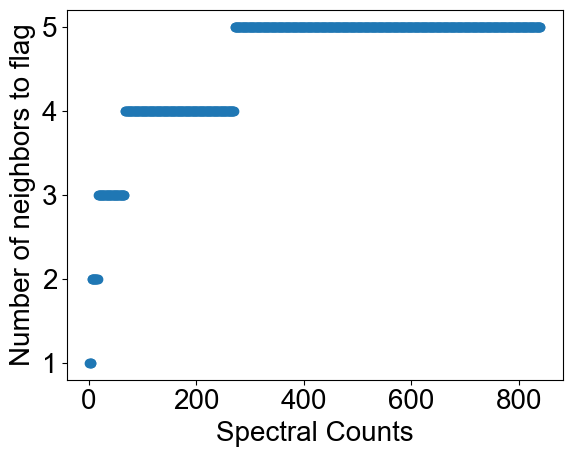

In [70]:
plt.scatter(check_spec, num_flag)
plt.xlabel('Spectral Counts')
plt.ylabel('Number of neighbors to flag')

In [71]:
for i in range(num_flag.shape[0]):
    print(check_spec[i], num_flag[i])

1 1.0
2 1.0
3 1.0
4 1.0
5 2.0
6 2.0
7 2.0
8 2.0
9 2.0
10 2.0
11 2.0
12 2.0
13 2.0
14 2.0
15 2.0
16 2.0
17 3.0
18 3.0
19 3.0
20 3.0
21 3.0
22 3.0
23 3.0
24 3.0
25 3.0
26 3.0
27 3.0
28 3.0
29 3.0
30 3.0
31 3.0
32 3.0
33 3.0
34 3.0
35 3.0
36 3.0
37 3.0
38 3.0
39 3.0
40 3.0
41 3.0
42 3.0
43 3.0
44 3.0
45 3.0
46 3.0
47 3.0
48 3.0
49 3.0
50 3.0
51 3.0
52 3.0
53 3.0
54 3.0
55 3.0
56 3.0
57 3.0
58 3.0
59 3.0
60 3.0
61 3.0
62 3.0
63 3.0
64 3.0
65 3.0
66 3.0
67 4.0
68 4.0
69 4.0
70 4.0
71 4.0
72 4.0
73 4.0
74 4.0
75 4.0
76 4.0
77 4.0
78 4.0
79 4.0
80 4.0
81 4.0
82 4.0
83 4.0
84 4.0
85 4.0
86 4.0
87 4.0
88 4.0
89 4.0
90 4.0
91 4.0
92 4.0
93 4.0
94 4.0
95 4.0
96 4.0
97 4.0
98 4.0
99 4.0
100 4.0
101 4.0
102 4.0
103 4.0
104 4.0
105 4.0
106 4.0
107 4.0
108 4.0
109 4.0
110 4.0
111 4.0
112 4.0
113 4.0
114 4.0
115 4.0
116 4.0
117 4.0
118 4.0
119 4.0
120 4.0
121 4.0
122 4.0
123 4.0
124 4.0
125 4.0
126 4.0
127 4.0
128 4.0
129 4.0
130 4.0
131 4.0
132 4.0
133 4.0
134 4.0
135 4.0
136 4.0
137 4.0
138 4.0
139 

#### flag

In [72]:
# optimized version -- dynamic checking for max thresh and =0, top if hit 0, left up to 2
# check each neighbor less than 1/2 of previous
# flag for contamination, loop through all preys, set flagged values to 0 (takes a few mins)
# checks if neighbor is less than half the adjacent max

contamination_thresh = 4 # min spectral counts to check for contamination
decay_thresh = 0.5 # only consider contamination if adjacent value is less than 1/2 its large neighbor
k = 1.4 # decay rate for determining number to flag

tot_flagged_max = 0
tot_flagged_neighbor = 0

gel_numbers = sheet.loc['Gel Number'].iloc[7:].copy()
sheet_numbers = sheet.loc['Sheet Number'].iloc[7:].copy()

flagged_spec_mat = spec_mat.copy()

flag_message = []

for i in tqdm(range(spec_mat.shape[0])):
#     print(i)
    vals = spec_mat[i]
    
    if np.any(vals >= contamination_thresh): # check that spectral counts aren't all below threshold
        max_val_inds = argrelextrema(vals, np.greater)[0]
        max_vals = vals[max_val_inds]
        
        # identify local maxima
        if np.all(vals[1:-1] < 1): # if only local maxes are first and/or last value
            max_val_inds = []
            if vals[0] >= contamination_thresh:
                max_val_inds.append(0)
            if vals[-1] >= contamination_thresh:
                max_val_inds.append(vals.shape[0]-1)
            max_val_inds = np.array(max_val_inds)
            max_vals = vals[max_val_inds]
        
        else:
            max_val_inds = argrelextrema(vals, np.greater)[0]
            max_vals = vals[max_val_inds]
        
#         plt.scatter(np.arange(0, vals.shape[0]), vals, c='#377eb8')
#         plt.scatter(max_val_inds, max_vals, c='orange')


        # flag neighbors of local maxima
        flag_inds = []
        flagged_max_inds = []
        for j in max_val_inds: # loop thru maxima
            val = vals[j]
            gel_num = gel_numbers[j]
            sheet_num = sheet_numbers[j]

            if val >= contamination_thresh:
                # check if adjacent values are 0 or above threshold --> if so, don't flag in that direction
                if (j != 0) and (vals[j-1] > 0): # check left
                    
                    
                    for n in range(min(exp_decay_num_flag(val, k), 2)): 
                    # limit to two for left flagging and must be in same gel and less than half previous neighbor and previous neighbor non-zero
                        if (j-n-1 >= 0) and (gel_num == gel_numbers[j-n-1]) and (vals[j-n-1] < vals[j-n]*decay_thresh): 
                            
                            if vals[j-n-1] == 0:
#                                 print('reached 0 left')
                                break # stop flagging if reach 0
    
                            flag_inds.append(j-n-1)
                            flagged_max_inds.append(j)
                
                if (j < vals.shape[0]-1) and (vals[j+1] > 0): # check right

                    for n in range(exp_decay_num_flag(val, k)): # must be in same sheet
                        if (j+n+1 <= vals.shape[0]-1) and (sheet_num == sheet_numbers[j+n+1]) and (vals[j+n+1] < vals[j+n]*decay_thresh): 
                            
                            if vals[j+n+1] == 0:
#                                 print('reached 0 right')
                                break # stop flagging if reach 0
    
                            flag_inds.append(j+n+1)
                            flagged_max_inds.append(j)
                        
        flag_inds = np.unique(np.array(flag_inds))
        
    else:
        flag_inds = np.array([])

    
    if flag_inds.shape[0] > 0:
#         plt.scatter(flag_inds, vals[flag_inds], c='r')
#         plt.xlim([374,390])

        flagged_max_inds = np.unique(np.array(flagged_max_inds))
        flagged_max = vals[flagged_max_inds]

#         plt.scatter(flagged_max_inds, flagged_max, c='purple')
    else:
        flagged_max_inds = np.array([])
        flagged_max = np.array([])
    
    tot_flagged_max += flagged_max.shape[0]
    tot_flagged_neighbor += flag_inds.shape[0]
    
    if flag_inds.shape[0] > 0:
        flagged_spec_mat[i, flag_inds] = 0
        flag_message.append('Prey %d, Set %d flagged spectral counts to 0' %(i, flag_inds.shape[0]))

100%|███████████████████████████████████| 13402/13402 [00:05<00:00, 2531.57it/s]


In [74]:
for m in flag_message:
    print(m)

Prey 0, Set 176 flagged spectral counts to 0
Prey 1, Set 657 flagged spectral counts to 0
Prey 2, Set 151 flagged spectral counts to 0
Prey 3, Set 276 flagged spectral counts to 0
Prey 4, Set 358 flagged spectral counts to 0
Prey 5, Set 510 flagged spectral counts to 0
Prey 6, Set 221 flagged spectral counts to 0
Prey 7, Set 350 flagged spectral counts to 0
Prey 8, Set 395 flagged spectral counts to 0
Prey 9, Set 182 flagged spectral counts to 0
Prey 10, Set 406 flagged spectral counts to 0
Prey 11, Set 149 flagged spectral counts to 0
Prey 12, Set 176 flagged spectral counts to 0
Prey 13, Set 351 flagged spectral counts to 0
Prey 14, Set 175 flagged spectral counts to 0
Prey 15, Set 388 flagged spectral counts to 0
Prey 16, Set 303 flagged spectral counts to 0
Prey 17, Set 489 flagged spectral counts to 0
Prey 19, Set 137 flagged spectral counts to 0
Prey 20, Set 485 flagged spectral counts to 0
Prey 21, Set 85 flagged spectral counts to 0
Prey 22, Set 364 flagged spectral counts to 0

In [82]:
new_spec_sheet = full_sheet.copy()
new_spec_sheet.iloc[13:,15:] = flagged_spec_mat

In [83]:
new_spec_sheet

,Unnamed: 0,Identified Proteins,Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Taxonomy,geneName,exp,PB-Chlamy,...,2722,2723,2724,2725,2726,2727,2728,2730,2731,2733
0,Sheet Number,0,0,0,0,0,0,0,0,0,...,77,77,77,77,77,77,77,77,77,77
1,Gel Number,0,0,0,0,0,0,0,0,0,...,351,351,351,351,352,352,352,352,352,352
2,Bait CreID,0,0,0,0,0,0,0,0,0,...,Cre12.g557250,Cre16.g692751,Cre04.g222700,Cre17.g731150,Cre10.g460050,Cre11.g467722,Cre17.g723650,Cre10.g419800,Cre03.g169400,Cre09.g396100
3,Bait Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1703_1202_85_11G9,LW_1703_1202_86_11C12,LW_1703_1202_87_11H4,LW_1703_1202_88_11G1,LW_1703_1202_89_11F7,LW_1703_1202_90_11F9,LW_1703_1202_91_11F6,LW_1703_1202_93_11F2,LW_1703_1202_94_11H6,LW_1703_1202_96_11H10
4,Bait Gene Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not Found,PDI3,EF3,Not Found,FLU1,Not Found,KAT1,PIS1,UXS1,PHC15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13410,13398,pacid=52510722 transcript=Cre03.g156600_4532.1...,Cre03.g156600_4532.1.p,Cre03.g156600,32 kDa,0,Cre03.g156600,GTRBP1,chloroplast/not homogeneous/not pyrenoid depleted,Chloroplast,...,0,0,0,0,1,0,0,0,0,0
13411,13399,pacid=52540355 transcript=Cre04.g216300_4532.1...,Cre04.g216300_4532.1.p,Cre04.g216300,18 kDa,0,Cre04.g216300,Not Found,Not Found,Other,...,0,0,0,0,0,0,0,0,0,0
13412,13400,pacid=52517051 transcript=Cre16.g653650_4532.1...,Cre16.g653650_4532.1.p,Cre16.g653650,22 kDa,0,Cre16.g653650,Not Found,Not Found,Chloroplast,...,0,0,0,0,0,0,0,0,1,0
13413,13401,pacid=52534323 transcript=Cre08.g377000_4532.1...,Cre08.g377000_4532.1.p,Cre08.g377000,10 kDa,0,Cre08.g377000,Not Found,secretory pathway/contractile vacuole; shapes ...,Secretory,...,0,0,0,0,0,0,0,0,0,0


In [181]:
# export new summary sheet to Excel
with pd.ExcelWriter(out_name, mode='w') as writer:  
    new_spec_sheet.to_excel(writer, sheet_name='flagged 0')